# Iris Flower Classification (sklearn iris dataset)


**Goal:** Build a project that loads the `sklearn` Iris dataset, performs EDA, preprocessing, trains multiple classification models, compares them, tunes the best model, evaluates final performance.
- Iris flower has three species; setosa, versicolor, and virginica, whichdiffers according to their measurements.

**What you'll find in this notebook:**


1. Problem statement & dataset
2. Imports & environment notes
3. Load dataset → pandas DataFrame
4. Exploratory Data Analysis (EDA)
5. Preprocessing & train/test split
6. Model comparison (multiple algorithms + cross-validation)
7. Hyperparameter tuning (GridSearchCV)
8. Final evaluation (classification report + confusion matrix)
9. Save model and example inference

In [1]:
#!pip install -q pandas numpy matplotlib seaborn scikit-learn joblib


[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#import required packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

import joblib

In [3]:
# configure plots
%matplotlib inline
sns.set(style='whitegrid')

## 2) Load the sklearn iris dataset and make a pandas DataFrame

In [4]:
iris = load_iris()
X = iris.data
y = iris.target

In [5]:
# create DataFrame for easy EDA
df = pd.DataFrame(X, columns=iris.feature_names)
df['species_id'] = y
df['species'] = pd.Categorical.from_codes(y, iris.target_names)

In [6]:
print("Dataset shape:", df.shape)

Dataset shape: (150, 6)


In [7]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species_id,species
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


## 3) Exploratory Data Analysis (EDA)
- Check class balance
- Summary statistics
- Pairplot for visual separation
- Correlation matrix

In [8]:
# class distribution
print(df['species'].value_counts())

species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


In [9]:
# summary statistics
display(df.describe())

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species_id
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [10]:
# check missing values
print('\nMissing values per column:')
print(df.isnull().sum())


Missing values per column:
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
species_id           0
species              0
dtype: int64


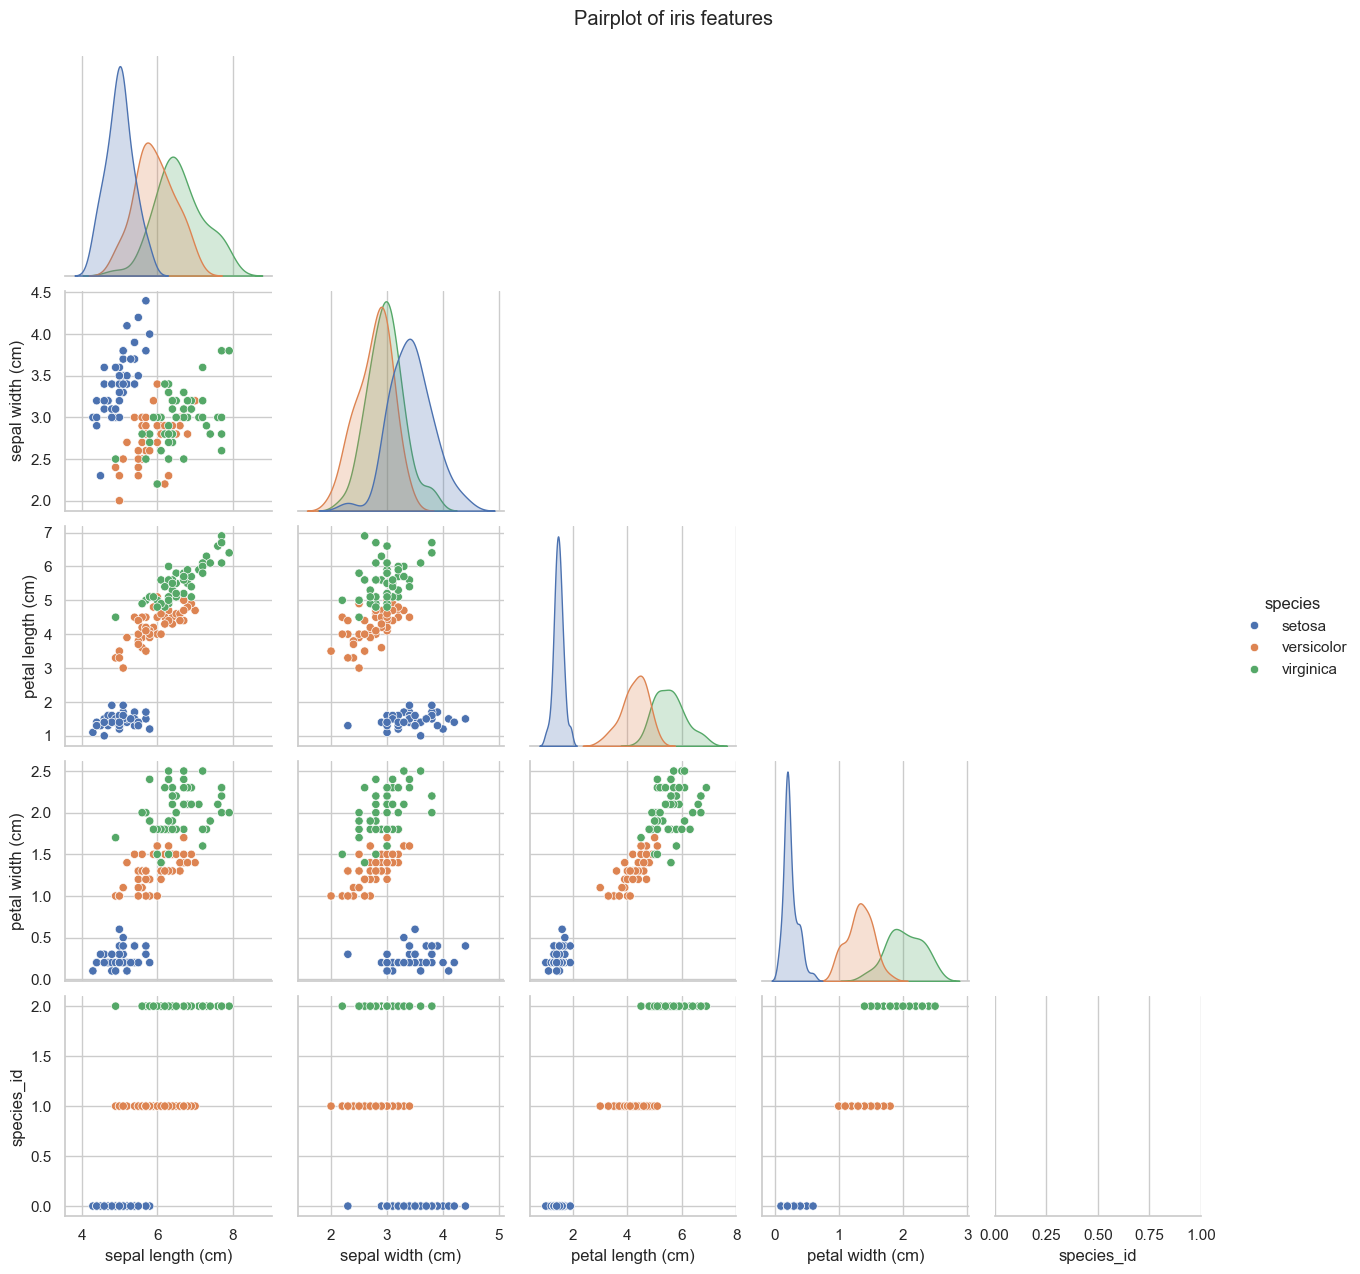

In [11]:
# pairplot (uncomment to plot — pairplot can be slow on some environments)
sns.pairplot(df, hue='species', corner=True)
plt.suptitle('Pairplot of iris features', y=1.02)
plt.show()

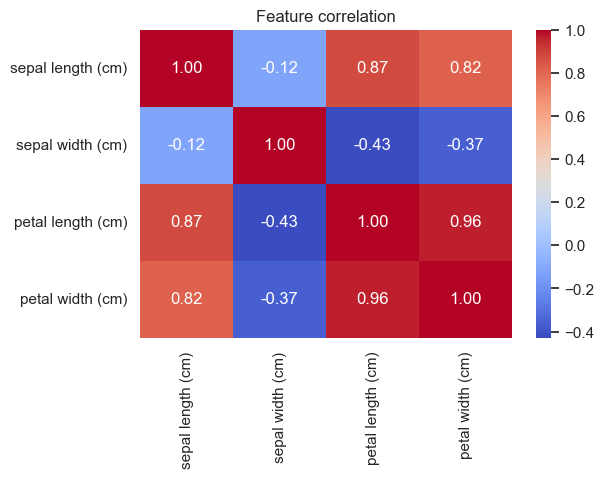

In [12]:
# correlation heatmap
plt.figure(figsize=(6,4))
corr = df.iloc[:, :4].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature correlation')
plt.show()

## 4) Preprocessing and train/test split
- We check there are no missing values
- Split data (stratify to preserve class distribution)
- Use StandardScaler inside pipelines for algorithms that benefit from scaling

In [13]:
# features and labels
X = df[iris.feature_names].values
y = df['species_id'].values

In [14]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
print('Train shape:', X_train.shape)
print('Test shape :', X_test.shape)

Train shape: (120, 4)
Test shape : (30, 4)


## 5) Baseline model comparison (multiple algorithms)
We'll build simple pipelines with `StandardScaler` + classifier (scaler won't hurt tree-based models)
and evaluate via 5-fold cross-validation on the training set and final test-set accuracy.

In [16]:
models = {
'Logistic Regression': LogisticRegression(max_iter=200),
'K-Nearest Neighbors' : KNeighborsClassifier(),
'Decision Tree' : DecisionTreeClassifier(random_state=42),
'Random Forest' : RandomForestClassifier(random_state=42),
'SVM (RBF)' : SVC(probability=True, random_state=42),
'Gaussian NB' : GaussianNB()
}

In [17]:
results = []

In [18]:
for name, clf in models.items():
    pipe = Pipeline([('scaler', StandardScaler()), ('clf', clf)])
    # cross-validate on training data
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')
    # fit on full training data and test on hold-out test set
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    
    
    results.append({
    'model': name,
    'cv_mean_accuracy': np.round(cv_scores.mean(), 4),
    'cv_std': np.round(cv_scores.std(), 4),
    'test_accuracy': np.round(test_acc, 4)
    })

In [19]:
results_df = pd.DataFrame(results).sort_values(by='test_accuracy', ascending=False).reset_index(drop=True)
results_df

,model,cv_mean_accuracy,cv_std,test_accuracy
0,SVM (RBF),0.9667,0.0312,0.9667
1,Gaussian NB,0.9583,0.0264,0.9667
2,K-Nearest Neighbors,0.9667,0.0312,0.9333
3,Logistic Regression,0.9583,0.0264,0.9333
4,Decision Tree,0.9417,0.0204,0.9333
5,Random Forest,0.9500,0.0167,0.9000


Interpretation:
- `results_df` shows CV accuracy and test accuracy for each model on the iris dataset.
- Pick one or two best models to tune further (usually RandomForest or SVM in this dataset).

## 6) Hyperparameter tuning (example: Random Forest and SVM)
We'll tune Random Forest and SVM with `GridSearchCV` using pipelines.

In [20]:
# Random Forest grid (pipeline)
rf_pipe = Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier(random_state=42))])
rf_param_grid = {
'clf__n_estimators': [50, 100, 200],
'clf__max_depth': [None, 3, 5, 10],
'clf__min_samples_split': [2, 4, 6]
}


rf_grid = GridSearchCV(rf_pipe, rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)
print('RandomForest best params:', rf_grid.best_params_)
print('RandomForest best CV score:', np.round(rf_grid.best_score_, 4))

RandomForest best params: {'clf__max_depth': 3, 'clf__min_samples_split': 2, 'clf__n_estimators': 50}
RandomForest best CV score: 0.9583


In [21]:
# SVM grid (pipeline)
svm_pipe = Pipeline([('scaler', StandardScaler()), ('clf', SVC(probability=True, random_state=42))])
svm_param_grid = {
'clf__C': [0.1, 1, 5, 10],
'clf__gamma': ['scale', 0.01, 0.1, 1.0],
'clf__kernel': ['rbf']
}
svm_grid = GridSearchCV(svm_pipe, svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_train)
print('SVM best params:', svm_grid.best_params_)
print('SVM best CV score:', np.round(svm_grid.best_score_, 4))

SVM best params: {'clf__C': 1, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}
SVM best CV score: 0.975


In [22]:
# compare best cross-val scores
pd.DataFrame([
{'model': 'RandomForest (best)', 'cv_score': rf_grid.best_score_},
{'model': 'SVM (best)', 'cv_score': svm_grid.best_score_}
])

,model,cv_score
0,RandomForest (best),0.958333
1,SVM (best),0.975000


## 7) Final evaluation on test set using the best tuned model
Pick the best model from the previous step and evaluate it on the hold-out test set.

In [24]:
# choose the best between rf_grid and svm_grid by cv score
best_model = rf_grid.best_estimator_ if rf_grid.best_score_ >= svm_grid.best_score_ else svm_grid.best_estimator_
print('Selected best model pipeline:', best_model)

Selected best model pipeline: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=1, gamma=0.1, probability=True, random_state=42))])


In [25]:
# evaluate on the test set
y_test_pred = best_model.predict(X_test)
print('\nTest Accuracy:', accuracy_score(y_test, y_test_pred))
print('\nClassification Report:\n')
print(classification_report(y_test, y_test_pred, target_names=iris.target_names))


Test Accuracy: 0.9666666666666667

Classification Report:

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



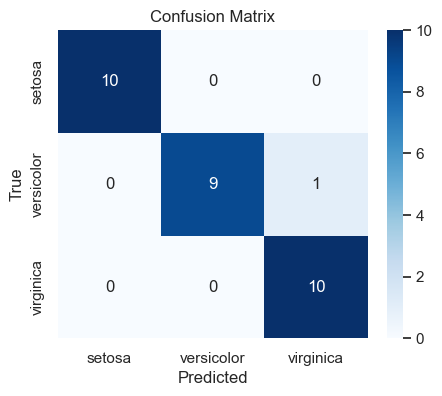

In [26]:
# confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,4))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

## 8) Conclusion
- In conclusion the best model for this data set is the SVM with accuracy of *0.97500*
- The results for confusion matrix shows that only the versicolor is True Negative for virginica which is False Positive